# Example Pipeline for Lalonde

This notebook is a proof-of-concept for generating causal samples from external samples

In [77]:
import contextlib
import sys
import os
sys.path.append("../")  # go to parent dir
# sys.path.append("../data/analysis/")  # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF
from frugal_flows.benchmarking import FrugalFlowModel
from benchmarking import compare_datasets
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score


import data.template_causl_simulations as causl_py
import data.analysis.validationMethods as valMethods
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

seed = 0
N = 2000
B = 50
sampling_size = 1000
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

lalonde = pd.read_csv('../data/filtered_lalonde_dataset.csv')
lalonde = lalonde

outcome_col = 're78'
treatment_col = 'treatment'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = lalonde.loc[lalonde[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()



def rescale_outcome(x, mean, std):
    return x * std + mean
    
cont_columns = ['age']
disc_columns = ['education', 'black', 'hispanic', 'married', 'nodegree']

lalonde[standardised_outcome_col] = (lalonde[outcome_col] - Y_control_mean) / Y_control_std
for col in cont_columns:
    mean = lalonde[col].mean()
    std = lalonde[col].std()
    lalonde[col] = (lalonde[col] - mean) / std

X = jnp.array(lalonde[treatment_col].values)[:, None]
Y = jnp.array(lalonde[standardised_outcome_col].values)[:, None]

covariate_colnames = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree']
# Z_disc = jnp.array(lalonde[['black', 'hispanic', 'married', 'nodegree']].values)
Z_disc = jnp.array(lalonde[disc_columns].values)
Z_cont = jnp.array(lalonde[cont_columns].values)
# Z_disc = jnp.array(lalonde[covariate_colnames].values)

lalonde_rescaled = lalonde[
    [standardised_outcome_col, treatment_col] + covariate_colnames
]

In [111]:
marginal_hyperparam_dict = {
    'learning_rate': 5e-4,
    # 'learning_rate': 0.2,
    'RQS_knots': 8,
    'flow_layers': 3,
    'nn_depth': 5,    
    'nn_width': 10,
    'max_patience': 100,
    'max_epochs': 20000
}

hyperparam_dict = {
    'learning_rate': 0.006335,
    # 'learning_rate': 0.2,
    'RQS_knots': 4,
    'flow_layers': 9,
    'nn_depth': 10,    
    'nn_width': 50,
    'max_patience': 100,
    'max_epochs': 20000
}
causal_margin_hyperparams_dict = {
    'learning_rate': 0.005,
    'RQS_knots': 8,
    'flow_layers': 10,
    'nn_depth': 20,    
    'nn_width': 50,
    'max_epochs': 20000,
    'max_patience': 200,
}
seed=1

true_ATE = 1000
benchmark_flow = FrugalFlowModel(Y=Y, X=X, Z_disc=Z_disc, Z_cont=Z_cont, confounding_copula=None)
benchmark_flow.train_benchmark_model(
    training_seed=jr.PRNGKey(seed),
    marginal_hyperparam_dict=marginal_hyperparam_dict,
    frugal_hyperparam_dict=hyperparam_dict,
    causal_model='location_translation',
    causal_model_args={'ate': 0, **causal_margin_hyperparams_dict},
    prop_flow_hyperparam_dict=hyperparam_dict
)

 14%|▏| 2762/20000 [02:56<18:19, 15.68it/s, train=0.4082114162380412, val=0.9477833197626404 (Max patien
  1%| | 224/20000 [00:42<1:02:52,  5.24it/s, train=-0.9896008239235462, val=0.2697239834837682 (Max pati
  1%| | 162/20000 [00:12<25:16, 13.08it/s, train=-0.37894882852587297, val=-0.04905648347270639 (Max pat


### Unconfounded Data

In [112]:
sim_data_df = benchmark_flow.generate_samples(
    key=jr.PRNGKey(10*seed),
    sampling_size=600,
    copula_param=0.,
    outcome_causal_model='location_translation',
    outcome_causal_args={'ate': true_ATE / Y_control_std},
    with_confounding=False
)
sim_data_df.columns = lalonde_rescaled.columns

Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.


In [113]:
sim_data_df['treatment'].value_counts()

treatment
0.0    402
1.0    198
Name: count, dtype: int64

In [114]:
lalonde_rescaled['treatment'].value_counts()

treatment
0    429
1    185
Name: count, dtype: int64

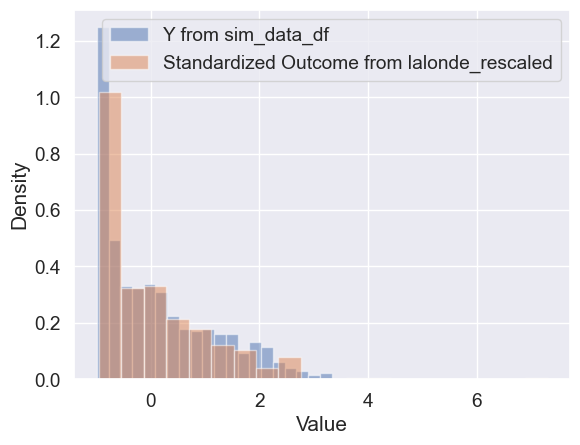

In [115]:
plotted_col = standardised_outcome_col#'education'
sim_data_df[plotted_col].hist(density=True, alpha=0.5, label='Y from sim_data_df', bins=20)
lalonde_rescaled[plotted_col].hist(density=True, alpha=0.5, label='Standardized Outcome from lalonde_rescaled', bins=20)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [116]:
lalonde_rescaled.head()

,re78_standardised,treatment,age,education,black,hispanic,married,nodegree
0,0.403868,1,0.975268,11,1,0,1,1
1,-0.464519,1,-0.542768,9,0,1,0,1
2,2.457483,1,0.266851,12,1,0,0,0
3,0.071561,1,-0.036756,11,1,0,0,1
4,-0.917772,1,0.570459,8,1,0,0,1


In [117]:
alphas = [0.1]#, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
k = 3
# cols = ['age', 'black', 'education']
cols = ["age", "education", "black", "hispanic", "married", "nodegree"]
# cols = ["treatment"]
lalonde_control = lalonde_rescaled.loc[lalonde_rescaled['treatment']==0]
sim_data_df_control = sim_data_df.loc[sim_data_df['treatment']==0]
compare_datasets(lalonde_rescaled.loc[:, cols].values, sim_data_df_control.loc[:, cols].values, alphas=alphas, k=3, n_permutations=1000)

Calculating Metrics...
MMD Calculated in 0.0114 seconds...
Energy Calculated in 0.0030 seconds...


{'MMD pval': 0.4009999930858612, 'Energy pval': 0.4869999885559082}

In [119]:
lalonde_control[cols + [standardised_outcome_col]].corr()

,age,education,black,hispanic,married,nodegree,re78_standardised
age,1.000000,-0.147709,-0.091816,-0.058757,0.392305,-0.049730,0.110418
education,-0.147709,1.000000,-0.025374,-0.192752,-0.117401,-0.721906,0.161626
black,-0.091816,-0.025374,1.000000,-0.205347,-0.227508,0.048263,-0.147505
hispanic,-0.058757,-0.192752,-0.205347,1.000000,-0.030473,0.130603,0.006688
married,0.392305,-0.117401,-0.227508,-0.030473,1.000000,-0.012188,0.186111
nodegree,-0.049730,-0.721906,0.048263,0.130603,-0.012188,1.000000,-0.139766
re78_standardised,0.110418,0.161626,-0.147505,0.006688,0.186111,-0.139766,1.000000


In [120]:
sim_data_df[cols + [standardised_outcome_col]].corr()

,age,education,black,hispanic,married,nodegree,re78_standardised
age,1.000000,0.000117,-0.131344,-0.005573,0.280264,-0.100081,0.091923
education,0.000117,1.000000,0.010429,-0.055881,-0.089170,-0.648405,-0.057084
black,-0.131344,0.010429,1.000000,-0.062603,-0.259182,-0.002115,0.045069
hispanic,-0.005573,-0.055881,-0.062603,1.000000,0.021542,-0.038670,0.049379
married,0.280264,-0.089170,-0.259182,0.021542,1.000000,-0.041307,0.113523
nodegree,-0.100081,-0.648405,-0.002115,-0.038670,-0.041307,1.000000,0.054511
re78_standardised,0.091923,-0.057084,0.045069,0.049379,0.113523,0.054511,1.000000


Text(0.5, 1.0, 'Generated NSW Data')

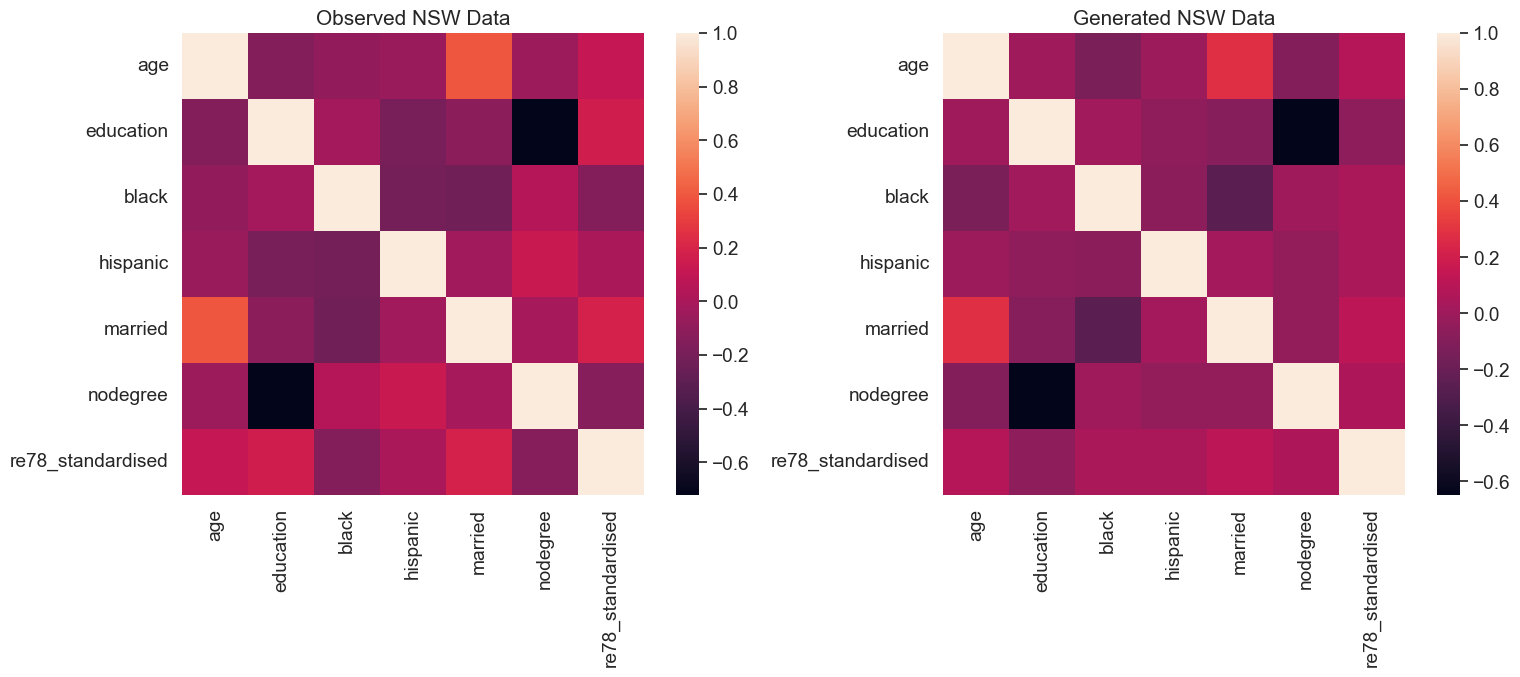

In [118]:
import seaborn as sns

sns.set(font_scale=1.25)
fig,ax = plt.subplots(ncols=2,figsize=(18,6))
sns.heatmap(lalonde_control[cols + [standardised_outcome_col]].corr(),ax=ax[0],square=True)
ax[0].set_title('Observed NSW Data')
sns.heatmap(sim_data_df[cols + [standardised_outcome_col]].corr(),ax=ax[1],square=True)
ax[1].set_title('Generated NSW Data')
# fig.savefig('Lalonde_NSW_0_1000_0.png')

In [4]:
non_confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=False
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    non_confounded_results_list.append(ate_reslts)
non_confounded_model_fit_results = pd.concat(non_confounded_results_list)
non_confounded_model_fit_results = non_confounded_model_fit_results.loc[
    ~non_confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
non_confounded_model_fit_results['ate'] = non_confounded_model_fit_results['ate'].apply(clean_ate)

Run 1 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 2 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 3 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 4 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 5 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 6 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 7 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 8 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 9 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 10 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 11 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 12 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 13 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 14 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 15 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 16 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 17 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 18 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 19 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 20 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 21 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 22 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 23 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 24 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 25 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 26 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 27 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 28 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 29 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 30 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 31 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 32 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 33 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 34 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 35 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 36 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 37 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 38 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 39 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 40 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 41 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 42 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 43 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 44 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 45 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 46 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 47 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 48 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 49 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 50 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


### Confounded Data

In [5]:
confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=True
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    confounded_results_list.append(ate_reslts)
confounded_model_fit_results = pd.concat(confounded_results_list)
confounded_model_fit_results = confounded_model_fit_results.loc[
    ~confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
confounded_model_fit_results['ate'] = confounded_model_fit_results['ate'].apply(clean_ate)

Run 1 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 2 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 3 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 4 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 5 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 6 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 7 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 8 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 9 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 10 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 11 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 12 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 13 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 14 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 15 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 16 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 17 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 18 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 19 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 20 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 21 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 22 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 23 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 24 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 25 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 26 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 27 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 28 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 29 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 30 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 31 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

Run 32 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 33 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 34 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 35 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 36 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 37 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 38 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 39 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 40 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 41 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 42 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 43 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 44 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 45 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 46 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 47 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

Run 48 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 49 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Run 50 / 50
(1000, 7)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
It looks like 'X' is not included in the outcome model.
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


### Hidden Confounded Data

In [ ]:
hidden_confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.5,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=True
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    hidden_confounded_results_list.append(ate_reslts)
hidden_confounded_model_fit_results = pd.concat(hidden_confounded_results_list)
hidden_confounded_model_fit_results = hidden_confounded_model_fit_results.loc[
    ~hidden_confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
hidden_confounded_model_fit_results['ate'] = hidden_confounded_model_fit_results['ate'].apply(clean_ate)

## Some demo plots

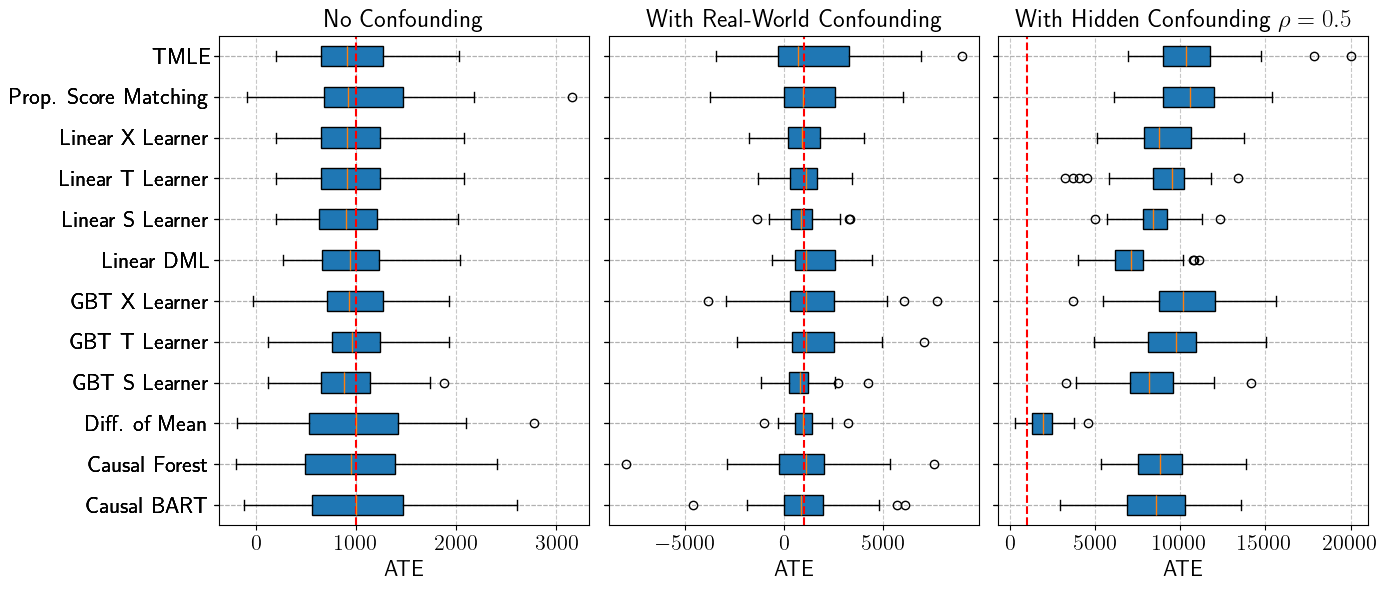

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

# Apply the cleaning function to the data
df1 = non_confounded_model_fit_results.copy()
df2 = confounded_model_fit_results.copy()
df3 = hidden_confounded_model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()
grouped_df3 = df3.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)

# Define a common font size
font_size = 16
title_fontsize = font_size + 2

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=true_ATE, color='red', linestyle='--')
axes[0].set_xlabel('ATE', fontsize=font_size)
axes[0].set_title('No Confounding', fontsize=title_fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=font_size)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=true_ATE, color='red', linestyle='--')
axes[1].set_xlabel('ATE', fontsize=font_size)
axes[1].set_title(r'With Real-World Confounding', fontsize=title_fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=font_size)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the third dataset
axes[2].boxplot(grouped_df3['ate'], vert=False, patch_artist=True, labels=grouped_df3['method'])
axes[2].axvline(x=true_ATE, color='red', linestyle='--')
axes[2].set_xlabel('ATE', fontsize=font_size)
axes[2].set_title(r'With Hidden Confounding $\rho=0.5$', fontsize=title_fontsize)
axes[2].tick_params(axis='both', which='major', labelsize=font_size)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('lalonde_box_and_whisker_plots.pdf', format='pdf')

# Display the plot
plt.show()